In [1]:
import numpy as np
from datetime import datetime 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchsummary import summary

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# What is AlexNet?

AlexNet is the name given to a Convolutional Neural Network Architecture that won the LSVRC competition in 2012.

LSVRC (Large Scale Visual Recognition Challenge) is a competition where research teams evaluate their algorithms on a huge dataset of labeled images (ImageNet) and compete to achieve higher accuracy on several visual recognition tasks. This made a huge impact on how teams approach the completion afterward.

# The Architecture of AlexNet

<img src='https://miro.medium.com/v2/resize:fit:1100/format:webp/0*pJ3o_2zTTNnixhKH.png' />

The AlexNet contains **8 layers** with weights;

**5 convolutional layers**

**3 fully connected layers.**

At the end of each layer, ReLu activation is performed except for the last one, which outputs with a softmax with a distribution over the 1000 class labels. Dropout is applied in the first two fully connected layers. As the figure above shows also applies Max-pooling after the first, second, and fifth convolutional layers. The kernels of the second, fourth, and fifth convolutional layers are connected only to those kernel maps in the previous layer, which reside on the same GPU. The kernels of the third convolutional layer are connected to all kernel maps in the second layer. The neurons in the fully connected layers are connected to all neurons in the previous layer.

**ReLU :**

An important feature of the AlexNet is the use of ReLU(Rectified Linear Unit) Nonlinearity.

Tanh or sigmoid activation functions used to be the usual way to train a neural network model.

AlexNet showed that using ReLU nonlinearity, deep CNNs could be trained much faster than using the saturating activation functions like tanh or sigmoid.

**The Overfitting Problem**. AlexNet had 60 million parameters, a major issue in terms of overfitting.

Two methods to reduce overfitting:

1. Data Augmentation
2. Dropout.

**Data Augmentation**

The authors generated image translations and horizontal reflections, which increased the training set by 2048. They also performed Principle Component Analysis (PCA) on the RGB pixel values to change RGB channels' intensities, which reduced the top-1 error rate by more than 1%.

**Dropout**

The second technique that AlexNet used to avoid overfitting was a dropout. It consists of setting to zero the output of each hidden neuron with a probability of 0.5. The neurons which are “dropped out” in this way do not contribute to the forward pass and do not participate in backpropagation. So every time an input is presented, the neural network samples a different architecture. This technique consists of turning off neurons with a predetermined probability. This means that every iteration, the neurons “turned off” do not contribute to the forward pass and do not participate in backpropagation.

## Loading the Dataset

In [3]:
def get_train_valid_loader(data_dir,
                           batch_size,
                           augment,
                           shuffle=True):

    # define normalizer
    normalize = transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2023, 0.1994, 0.2010])    # Normalize a tensor image with mean and standard deviation for n channels, this transform will normalize each channel of the input.


    # define transforms
    valid_transform = transforms.Compose([
                transforms.Resize((227,227)),
                transforms.ToTensor(),          # transforms.ToTensor() automatically scales the images to [0,1] range
                normalize])


    if augment:
            train_transform = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                normalize,
            ])
    else:
            train_transform = transforms.Compose([
                transforms.Resize((227,227)),
                transforms.ToTensor(),
                normalize,
            ])

    # download and create datasets
    train_dataset = datasets.CIFAR10(root=data_dir, train=True, transform=train_transform, download=True)
    valid_dataset = datasets.CIFAR10(root=data_dir, train=False, transform=valid_transform, download=True)

    # define the data loaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle = shuffle)
    valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=shuffle)

    return (train_dataset, valid_dataset, train_loader, valid_loader)

BATCH_SIZE = 64
train_dataset, valid_dataset, train_loader, valid_loader = get_train_valid_loader(data_dir = 'CIFAR10_data',
                                                    batch_size = 64,
                                                    augment = True,
                                                    random_seed = 1)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting CIFAR10_data/cifar-10-python.tar.gz to CIFAR10_data
Files already downloaded and verified


# Plotting the Images

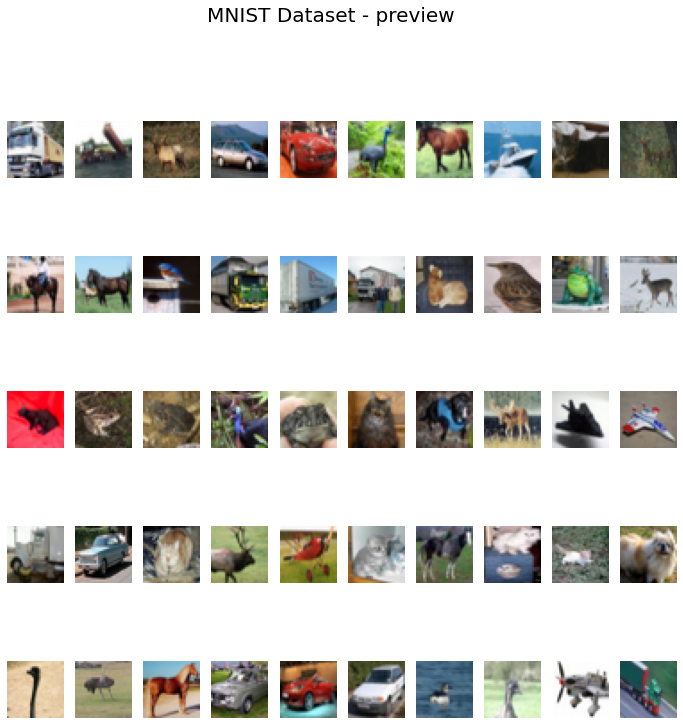

In [4]:

N_COLS = 10
N_ROWS = 5

fig = plt.figure(figsize=(12,12))
for index in range(1, N_COLS*N_ROWS + 1):
  plt.subplot(N_ROWS, N_COLS, index)
  plt.axis('off')
  plt.imshow(train_dataset.data[index])
fig.suptitle('MNIST Dataset - preview', fontsize=20);

# AlexNet Model

In [5]:
from torch.nn.modules.container import Sequential
class AlexNet(nn.Module):
    def __init__(self, NUM_CLASSES=10):
        super(AlexNet, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96,kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=384,kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=384,kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256,kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features=9216, out_features=4096),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features=4096,out_features=4096),
            nn.ReLU())
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=NUM_CLASSES))
        

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0),-1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

# Train Loop

In [6]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''

    correct_pred = 0
    n = 0


    with torch.no_grad():
        model.eval()
        for X,y_true in data_loader:

          X = X.to(device)
          y_true = y_true.to(device)

          y_hat = model(X)
          y_prob = F.softmax(y_hat, dim=1)
          _, predicted_labels = torch.max(y_prob,1)

          n += y_true.size(0)
          correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''

    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))
    ax.plot(train_losses, color='blue', label= 'Training loss')
    ax.plot(valid_losses, color='red', label= 'Validation loss')
    ax.set(title='Loss over epochs',
           xlabel='Epoch',
           ylabel='Loss')
    plt.legend()
    plt.show()

    # change the plot style to default
    plt.style.use('default')

def train(train_loader, model,criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''
    
    model.train()    
    running_loss = 0

    for X, y_true in train_loader:

        optimizer.zero_grad()           # Sets the gradients of all optimized torch.Tensor s to zero.

        X = X.to(device)
        y_true = y_true.to(device)

        # forward paas
        y_hat = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item()*X.size(0)        # X.size() ----> Returns the size of the self tensor

        # Backward pass
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader.dataset)
      
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

def training_loop(model, criterion, optimizer, train_loader, valid_loader,epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''

    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []


    # Train model
    for epoch in range(0,epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model,criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every -1):

            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)

            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch + 1}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses)

# Setting Hyperparameters

In [8]:
NUM_EPOCHS = 20
NUM_CLASSES = 10
LEARNING_RATE = 0.005

torch.manual_seed(42)
model = AlexNet(NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=0.005)


x = torch.randn(100,3,227,227)
x = x.to(device)
output = model(x)
print(output.shape)
summary(model, (3,227,227))

torch.Size([100, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
       BatchNorm2d-2           [-1, 96, 55, 55]             192
              ReLU-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
       BatchNorm2d-6          [-1, 256, 27, 27]             512
              ReLU-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
      BatchNorm2d-10          [-1, 384, 13, 13]             768
             ReLU-11          [-1, 384, 13, 13]               0
           Conv2d-12          [-1, 384, 13, 13]       1,327,488
      BatchNorm2d-13          [-1, 384, 13, 13]             768
             ReLU

In [9]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, NUM_EPOCHS, device)

RuntimeError: ignored

In [ ]:
# Save model
torch.save(model.state_dict(),'/content/drive/MyDrive/Colab Notebooks/Github/FromScratch/LeNET5 Pytorch/AlexNET.pt')

In [ ]:
# Load model
model = AlexNet()
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Github/FromScratch/LeNET5 Pytorch/LeNET5.pt'))

# Evaluating the predictions

In [ ]:
N_COLS = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1,  N_COLS* N_ROWS + 1):
    plt.subplot(N_ROWS, N_COLS, index)
    plt.axis('off')
    plt.imshow(valid_dataset.data[index], cmap='gray_r')

    with torch.no_grad():
        model.eval()
        _,probs = model(valid_dataset[index][0].unsqueeze(0))

    title = f'{torch.argmax(probs)}  ({torch.max(probs * 100):.0f}%)'

    plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 - predictions');
     